Wheat Detection - Kaggle Competition

Load Yolov5

In [1]:
!git clone https://github.com/samthomp/yolov5 # clone repo

Cloning into 'yolov5'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 612 (delta 1), reused 0 (delta 0), pack-reused 604
Receiving objects: 100% (612/612), 3.31 MiB | 2.31 MiB/s, done.
Resolving deltas: 100% (396/396), done.


In [2]:
%cd yolov5
!pip install -U -r requirements.txt

/content/yolov5
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ie1uvyl7
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ie1uvyl7
Requirement already up-to-date: Cython in /usr/local/lib/python3.6/dist-packages (from -r requirements.txt (line 2)) (0.29.20)
     |████████████████████████████████| 20.4MB 65.2MB/s 
     |████████████████████████████████| 28.2MB 78kB/s 
     |████████████████████████████████| 753.2MB 19kB/s 
     |████████████████████████████████| 12.4MB 243kB/s 
     |████████████████████████████████| 2.1MB 48.2MB/s 
Requirement already up-to-date: tensorboard in /usr/local/lib/python3.6/dist-packages (from -r requirements.txt (line 8)) (2.2.2)
     |████████████████████████████████| 276kB 44.7MB/s 
     |████████████████████████████████| 6.6MB 36.6MB/s 
Requirement already up-to-date: scipy in /usr/local/lib/python3.6/dist-packages (from -r requirements.txt (line 11)) (1.4.1)
     |██████████████████

Split CSV into multiple Data Files

In [1]:
# download dataset
!python3 -c "from yolov5.utils.google_utils import gdrive_download; gdrive_download('1IYCtw7fVifziVnwBzo1WNCdwV22nsEkd','wheat.zip')" 


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1511      0 --:--:-- --:--:-- --:--:--  1505
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  607M    0  607M    0     0  42.6M      0 --:--:--  0:00:14 --:--:-- 56.0M


In [2]:
import pandas as pd
import numpy as np
import os
from os import path

In [3]:
from ast import literal_eval
import cv2
import matplotlib.pyplot as plt
import glob
import shutil

In [4]:
%cd /content
!ls

/content
sample_data  wheat  yolov5


In [5]:
boxes_df = pd.read_csv('wheat/train.csv')
boxes_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [6]:
## External code pabloberhauser kaggle

def convert(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

def convert_to_yolo_label(coco_format_box, w = 1024, h = 1024):

  xarr = coco_format_box.strip('[]').split(",") #.astype(float)
  xarr = np.array(xarr)
  bbox = xarr.astype(float)
    
  xmin = bbox[0]
  xmax = bbox[0] + bbox[2]
  ymin = bbox[1]
  ymax = bbox[1] + bbox[3]
  b = (float(xmin), float(xmax), float(ymin), float(ymax))
  yolo_box = convert((w, h), b)
  
  # Sanity check on calculations - Take this opportunity to check that conversion works
  if np.max(yolo_box) > 1 or np.min(yolo_box) < 0: 
      print("BOX HAS AN ISSUE")
  return str(yolo_box)

In [7]:
boxes_df['yolo_box'] = boxes_df.bbox.apply(convert_to_yolo_label)

In [8]:
boxes_df.head()

,image_id,width,height,bbox,source,yolo_box
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,"[0.841796875, 0.234375, 0.0546875, 0.03515625]"
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,"[0.2841796875, 0.5634765625, 0.126953125, 0.05..."
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,"[0.404296875, 0.5703125, 0.072265625, 0.15625]"
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,"[0.86767578125, 0.14501953125, 0.1064453125, 0..."
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,"[0.0859375, 0.19775390625, 0.12109375, 0.11425..."


In [9]:
# expand column and normalize into darknet format
expanded_cols = ['x_center', 'y_center', 'bb_width', 'bb_height']
boxes_df['bbox_cords'] = boxes_df['yolo_box'].str.strip('[]')
boxes_df[expanded_cols] = boxes_df['bbox_cords'].str.split(",", expand=True).astype(float)
boxes_df['class'] = 0
expanded_cols = ['class', 'x_center', 'y_center', 'bb_width', 'bb_height']
t_boxes_df = boxes_df[expanded_cols]

In [10]:
t_boxes_df.head()

,class,x_center,y_center,bb_width,bb_height
0,0,0.841797,0.234375,0.054688,0.035156
1,0,0.284180,0.563477,0.126953,0.056641
2,0,0.404297,0.570312,0.072266,0.156250
3,0,0.867676,0.145020,0.106445,0.104492
4,0,0.085938,0.197754,0.121094,0.114258


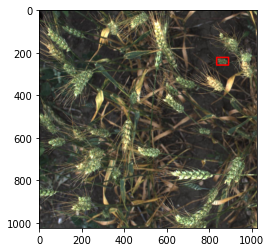

In [11]:
## Check that we can visualize boxes as Coco format:
fr = cv2.imread("wheat/images/train/b6ab77fd7.jpg")
frame_rgb = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
frame_rgb = cv2.rectangle(frame_rgb, (834, 222), (834+56, 222+36), (255, 0, 0), 5)
plt.imshow(frame_rgb)

In [12]:
print("We have {} unique images with boxes.".format(len(boxes_df.image_id.unique())))
unique_img_ids = boxes_df.image_id.unique()

We have 3373 unique images with boxes.


Generate label files in the format that YOLO is expecting.

In [13]:
images_path = "wheat/images/train/"
labels_path = "wheat/labels/train/"

def write_bboxfiles ():

  failed_count = 0
  avail_count = 0

  image_names = boxes_df['image_id'].unique()
  for name in image_names:
    fpath = labels_path  + name + '.txt'
    image = images_path + name + '.jpg'
    
    if (os.path.isfile(image)):
      temp_df = boxes_df[boxes_df['image_id'] == name]
      temp_df[expanded_cols].to_csv(fpath, header=None, index=None, sep=' ')
      avail_count = avail_count + 1

    else:    
      failed_count = failed_count + 1

  print(failed_count, avail_count)

  return 

def delete_txtlabels ():

  image_names = boxes_df['image_id'].unique()
  for name in image_names:
    fpath = labels_path + name + '.txt'    
    os.system("rm " + fpath)

  return

#delete_txtlabels ()
write_bboxfiles ()

0 3373


We need to also make labels for the training images that do not have bounding boxes in them.
This should be a lot easier since we just need an empty file with the name of the image

In [14]:
all_imgs = glob.glob("wheat/images/train/*.jpg")
all_imgs = [i.split("/")[-1].replace(".jpg", "") for i in all_imgs]
positive_imgs = boxes_df.image_id.unique()

In [15]:
negative_images = set(all_imgs) - set(positive_imgs)
print(len(all_imgs), len(positive_imgs), len(negative_images))

3422 3373 49


In [16]:
for i in list(negative_images):
    file_name = "wheat/labels/train/{}.txt".format(i)
    print(file_name)
    #with open(file_name, 'w') as fp: 
      #pass
    fname = "{}.txt".format(i)
    fpath = "wheat/labels/train/"
    with open(os.path.join( fpath, fname), 'w') as fp: 
        pass

wheat/labels/train/e4ec17f9b.txt
wheat/labels/train/83a94fc79.txt
wheat/labels/train/ec196d18a.txt
wheat/labels/train/ed00a614d.txt
wheat/labels/train/c74ca81bd.txt
wheat/labels/train/a3ce975cd.txt
wheat/labels/train/5901a73fe.txt
wheat/labels/train/00b5c6764.txt
wheat/labels/train/b45c5294d.txt
wheat/labels/train/e01ad95cf.txt
wheat/labels/train/155c440e8.txt
wheat/labels/train/91d4e3750.txt
wheat/labels/train/ffbb9c623.txt
wheat/labels/train/cf1d2f504.txt
wheat/labels/train/8de789df8.txt
wheat/labels/train/39a0e5556.txt
wheat/labels/train/65d0b13aa.txt
wheat/labels/train/3116768f0.txt
wheat/labels/train/dd5d2fa9e.txt
wheat/labels/train/f9cafa47f.txt
wheat/labels/train/0cf7ef43d.txt
wheat/labels/train/581eaf87b.txt
wheat/labels/train/8425a537b.txt
wheat/labels/train/f530a5d4b.txt
wheat/labels/train/ab20ec355.txt
wheat/labels/train/cfc9040ca.txt
wheat/labels/train/2d80f9c49.txt
wheat/labels/train/dec23c826.txt
wheat/labels/train/952e7d15c.txt
wheat/labels/train/d771bb084.txt
wheat/labe

Split the data into train and test

In [17]:
def split_testset ():
  n = 300

  all_imgs = glob.glob("wheat/images/train/*.jpg")
  all_imgs = [i.split("/")[-1].replace(".jpg", "") for i in all_imgs]
  test_set = all_imgs[-n:] 

  for image_labels in test_set:
      shutil.move("wheat/labels/train/{}.txt".format(image_labels), 'wheat/labels/val/')
      shutil.move("wheat/images/train/{}.jpg".format(image_labels), 'wheat/images/val/')

  return True

split_testset ()

True

In [18]:
%cd yolov5
!ls

/content/yolov5
data	    hubconf.py	models		  test.py	  utils
detect.py   inference	README.md	  train.py	  weights
Dockerfile  LICENSE	requirements.txt  tutorial.ipynb


In [20]:
!python train.py --img 640 --batch 16 --epochs 3 --data ./data/wheat.yaml --cfg ./models/yolov5lw.yaml --weights yolov5l.pt 

Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
{'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.36, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0}
Namespace(adam=False, batch_size=16, bucket='', cache_images=False, cfg='./models/yolov5lw.yaml', data='./data/wheat.yaml', device='', epochs=3, evolve=False, img_size=[640], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=False, single_cls=False, weights='yolov5l.pt')
Using CPU

2020-06-18 18:22:07.078394: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/

              from  n    params  module                                  arguments             

In [30]:
!python test.py --img 640 --data ./data/wheat.yaml --iou-thres 0.4 --weights weights/last.pt  --single-cls

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='./data/wheat.yaml', device='', img_size=640, iou_thres=0.4, save_json=False, single_cls=True, task='val', verbose=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Model Summary: 309 layers, 4.98374e+07 parameters, 0 gradients
Fusing layers...
Model Summary: 216 layers, 4.98087e+07 parameters, 4.77048e+07 gradients
Caching labels ../wheat/labels/val (297 found, 0 missing, 3 empty, 0 duplicate, for 300 images): 100% 300/300 [00:00<00:00, 5806.28it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 10/10 [00:22<00:00,  2.29s/it]
                 all         300     1.3e+04        0.75       0.909       0.903       0.407
Speed: 16.7/3.0/19.7 ms inference/NMS/total per 640x640 image at batch-size 32


Save Model to Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cp /content/yolov5/weights/last.pt  "/content/gdrive/My Drive/Colab Notebooks/WheatDetection"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
cp: target 'Notebooks/WheatDetection' is not a directory


Opt Reload Model from Drive

In [14]:
%cp "/content/gdrive/My Drive/Colab Notebooks/WheatDetection/last.pt" /content/yolov5/weights

anscombe.json*                mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md*
